In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import json
from tqdm import tqdm
import gc
import warnings
warnings.filterwarnings('ignore')

In [36]:
num_epochs = 15

In [30]:
# Cell 3: Load and Preprocess Data
#recipes_df = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv')
recipes_df = pd.read_csv('./Data/RAW_recipes.csv')
# Convert ingredients list from string to actual list
recipes_df['ingredients'] = recipes_df['ingredients'].apply(eval)

# Create text format for each recipe
def format_recipe(row):
    return f"Ingredients: {', '.join(row['ingredients'])}\nInstructions: {row['steps']}"

recipes_df['formatted_text'] = recipes_df.apply(format_recipe, axis=1)
print(f"Total recipes loaded: {len(recipes_df)}")
print("\nSample formatted recipe:")
print(recipes_df['formatted_text'].iloc[0])


Total recipes loaded: 231637

Sample formatted recipe:
Ingredients: winter squash, mexican seasoning, mixed spice, honey, butter, olive oil, salt
Instructions: ['make a choice and proceed with recipe', 'depending on size of squash , cut into half or fourths', 'remove seeds', 'for spicy squash , drizzle olive oil or melted butter over each cut squash piece', 'season with mexican seasoning mix ii', 'for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece', 'season with sweet mexican spice mix', 'bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin', 'be careful not to burn the squash especially if you opt to use sugar or butter', 'if you feel more comfortable , cover the squash with aluminum foil the first half hour , give or take , of baking', 'if desired , season with salt']


In [44]:
print(recipes_df.columns)

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'formatted_text'],
      dtype='object')


In [31]:
# Cell 4: Define Dataset Class
class RecipeDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        input_ids = encodings['input_ids'].squeeze()
        attention_mask = encodings['attention_mask'].squeeze()
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': input_ids
        }


In [32]:
# Cell 5: Define Model Architecture
class LightweightGPT2(nn.Module):
    def __init__(self, vocab_size, hidden_size=256, num_layers=4, num_heads=4):
        super().__init__()
        self.config = GPT2Config(
            vocab_size=vocab_size,
            n_positions=512,
            n_ctx=512,
            n_embd=hidden_size,
            n_layer=num_layers,
            n_head=num_heads,
            bos_token_id=50256,
            eos_token_id=50256
        )
        self.model = GPT2LMHeadModel(self.config)
    
    def forward(self, input_ids, attention_mask=None, labels=None):
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )


In [33]:
# Cell 6: Initialize Tokenizer and Create Datasets
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# Split data
train_texts, val_texts = train_test_split(
    recipes_df['formatted_text'].tolist(),
    test_size=0.1,
    random_state=42
)

# Create datasets
train_dataset = RecipeDataset(train_texts, tokenizer)
val_dataset = RecipeDataset(val_texts, tokenizer)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")



Training samples: 208473
Validation samples: 23164


In [ ]:
print(val_dataset)

In [34]:
# Cell 7: Initialize Model and Training Components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = LightweightGPT2(vocab_size=tokenizer.vocab_size)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    #num_training_steps=len(train_loader) * 3  # 3 epochs
    num_training_steps=len(train_loader) * num_epochs
)


Using device: cuda


In [35]:
train_loss = []
val_loss = []

In [37]:
# Cell 8: Training Loop
#num_epochs = 5
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    # Validation phase
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            total_val_loss += outputs.loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    
    print(f'Epoch {epoch + 1}:')
    print(f'Average training loss: {avg_train_loss:.4f}')
    train_loss.append(avg_train_loss)
    print(f'Average validation loss: {avg_val_loss:.4f}')
    val_loss.append(avg_val_loss)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        #torch.save(model.state_dict(), '/kaggle/working/best_recipe_model.pth')
        torch.save(model.state_dict(), './save/best_recipe_model.pth')
        print("Saved new best model!")


Validation: 100%|██████████| 2896/2896 [02:10<00:00, 22.20it/s]


Epoch 1:
Average training loss: 0.9919
Average validation loss: 0.7435
Saved new best model!


Validation: 100%|██████████| 2896/2896 [02:10<00:00, 22.23it/s]


Epoch 2:
Average training loss: 0.7346
Average validation loss: 0.6791
Saved new best model!


Validation: 100%|██████████| 2896/2896 [02:11<00:00, 22.08it/s]


Epoch 3:
Average training loss: 0.6911
Average validation loss: 0.6503
Saved new best model!


Validation: 100%|██████████| 2896/2896 [02:09<00:00, 22.29it/s]


Epoch 4:
Average training loss: 0.6682
Average validation loss: 0.6346
Saved new best model!


Validation: 100%|██████████| 2896/2896 [02:11<00:00, 22.06it/s]


Epoch 5:
Average training loss: 0.6535
Average validation loss: 0.6229
Saved new best model!


Validation: 100%|██████████| 2896/2896 [02:09<00:00, 22.35it/s]


Epoch 6:
Average training loss: 0.6430
Average validation loss: 0.6154
Saved new best model!


Validation: 100%|██████████| 2896/2896 [02:11<00:00, 22.11it/s]


Epoch 7:
Average training loss: 0.6349
Average validation loss: 0.6090
Saved new best model!


Validation: 100%|██████████| 2896/2896 [02:10<00:00, 22.27it/s]


Epoch 8:
Average training loss: 0.6285
Average validation loss: 0.6036
Saved new best model!


Validation: 100%|██████████| 2896/2896 [02:11<00:00, 22.06it/s]


Epoch 9:
Average training loss: 0.6233
Average validation loss: 0.6003
Saved new best model!


Validation: 100%|██████████| 2896/2896 [02:10<00:00, 22.16it/s]


Epoch 10:
Average training loss: 0.6189
Average validation loss: 0.5968
Saved new best model!


Validation: 100%|██████████| 2896/2896 [02:10<00:00, 22.12it/s]


Epoch 11:
Average training loss: 0.6151
Average validation loss: 0.5938
Saved new best model!


Validation: 100%|██████████| 2896/2896 [02:11<00:00, 22.01it/s]


Epoch 12:
Average training loss: 0.6120
Average validation loss: 0.5915
Saved new best model!


Validation: 100%|██████████| 2896/2896 [02:10<00:00, 22.21it/s]


Epoch 13:
Average training loss: 0.6090
Average validation loss: 0.5893
Saved new best model!


Validation: 100%|██████████| 2896/2896 [02:10<00:00, 22.27it/s]


Epoch 14:
Average training loss: 0.6067
Average validation loss: 0.5881
Saved new best model!


Validation: 100%|██████████| 2896/2896 [02:09<00:00, 22.28it/s]


Epoch 15:
Average training loss: 0.6049
Average validation loss: 0.5873
Saved new best model!


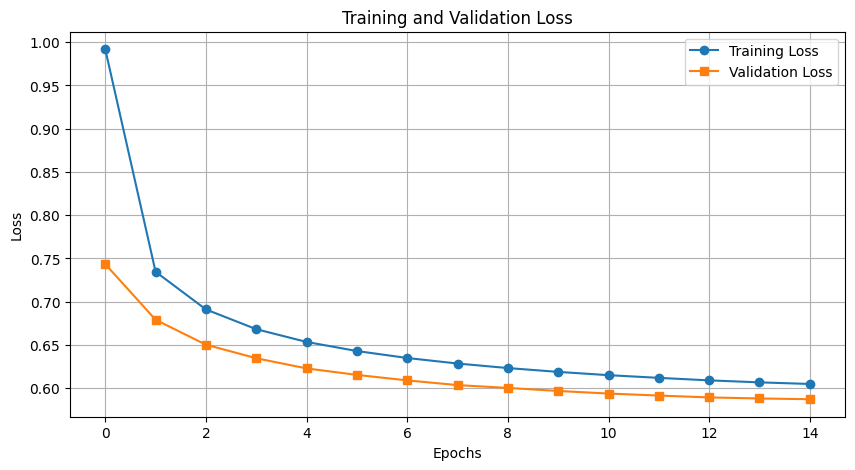

In [38]:
# Plot losses
import matplotlib.pyplot as plt

def plot_loss(train_loss, val_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(train_loss, val_loss)

In [40]:
# Cell 9: Model Quantization
model.eval()
quantized_model = torch.quantization.quantize_dynamic(
    model,
    {torch.nn.Linear},
    dtype=torch.qint8
)

# Save quantized model
#torch.save(quantized_model.state_dict(), '/kaggle/working/quantized_recipe_model.pth')
torch.save(quantized_model.state_dict(), './save/quantized_recipe_model.pth')
# Save tokenizer
tokenizer.save_pretrained('./save_token/')

print("Models and tokenizer saved successfully!")

Models and tokenizer saved successfully!


In [25]:
# Cell 10: Test Generation Function
def generate_recipe(ingredients, model, tokenizer, device):
    model.eval()
    
    # Format input
    input_text = f"Ingredients: {', '.join(ingredients)}\nInstructions:"
    
    # Tokenize input
    inputs = tokenizer(
        input_text,
        return_tensors='pt',
        max_length=512,
        truncation=True,
        padding=True
    ).to(device)
    
    # Generate recipe
    with torch.no_grad():
        outputs = model.model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=512,
            num_return_sequences=1,
            temperature=0.7,
            top_p=0.9,
            do_sample=True
        )
    
    # Decode and return recipe
    recipe = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return recipe


In [43]:
# Cell 11: Test the Model
test_ingredients = ['chicken breast', 'rice', 'soy sauce', 'garlic']
recipe = generate_recipe(test_ingredients, model, tokenizer, device)
print("Generated Recipe:")
print(recipe)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Recipe:
Ingredients: chicken breast, rice, soy sauce, garlic
Instructions: ['cut chicken into bite size pieces and place in a bowl', 'mix soy sauce , garlic and salt and pour over chicken', 'marinate in refrigerator for 30 minutes', 'drain and place chicken on a baking sheet', 'bake at 375 for 30 minutes', 'baste with soy sauce mixture']
